# Trees Regression example

In [3]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz 

from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor, export_graphviz 
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Load in same wine dataset from last week, let's preprocess!

In [4]:
#Read in the data from the github repo, you should also have this saved locally...
winequality = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/winequality-red-ddl.csv")

In [5]:
#Let's take a look...
print(winequality.info()) #Some NA's

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1575 non-null   float64
 2   citric acid           1595 non-null   float64
 3   residual sugar        1586 non-null   float64
 4   chlorides             1587 non-null   float64
 5   free sulfur dioxide   1583 non-null   float64
 6   total sulfur dioxide  1574 non-null   float64
 7   density               1579 non-null   float64
 8   pH                    1597 non-null   float64
 9   sulphates             1591 non-null   float64
 10  alcohol               1589 non-null   float64
 11  quality               1581 non-null   float64
 12  text_rank             1581 non-null   object 
dtypes: float64(12), object(1)
memory usage: 162.5+ KB
None


In [6]:
#drop NA's and create a new dataframe to preserve our working environment
winequality_1 = winequality.dropna()

In [7]:
#In order to use tree regression in python, all features must be numeric
print(winequality_1.dtypes)#Going to need to change text_rank

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
text_rank                object
dtype: object


In [8]:
#Take a look at value counts beforehand 
print(winequality_1["text_rank"].value_counts())

text_rank
ave            635
average-ish    583
good           186
poor-ish        51
excellent       17
poor            10
Name: count, dtype: int64


In [9]:
#encode text_rank to become a continuous variable so it can be applied to sklearn's decision tree regressor function
winequality_1[["text_rank"]] = OrdinalEncoder().fit_transform(winequality_1[["text_rank"]])
print(winequality_1["text_rank"].value_counts()) #Looks good


text_rank
0.0    635
1.0    583
3.0    186
5.0     51
2.0     17
4.0     10
Name: count, dtype: int64


/var/folders/ks/dtpzjwpd0zlcrpw8t81ybvrr0000gn/T/ipykernel_17866/2807622371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winequality_1[["text_rank"]] = OrdinalEncoder().fit_transform(winequality_1[["text_rank"]])


In [10]:
print(winequality_1.info()) #check if all numeric, yep!

<class 'pandas.core.frame.DataFrame'>
Index: 1482 entries, 0 to 1580
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1482 non-null   float64
 1   volatile acidity      1482 non-null   float64
 2   citric acid           1482 non-null   float64
 3   residual sugar        1482 non-null   float64
 4   chlorides             1482 non-null   float64
 5   free sulfur dioxide   1482 non-null   float64
 6   total sulfur dioxide  1482 non-null   float64
 7   density               1482 non-null   float64
 8   pH                    1482 non-null   float64
 9   sulphates             1482 non-null   float64
 10  alcohol               1482 non-null   float64
 11  quality               1482 non-null   float64
 12  text_rank             1482 non-null   float64
dtypes: float64(13)
memory usage: 162.1 KB
None


## Splitting the Data

In [11]:
#split independent and dependent variables, alcohol will be our target variable in this example
X= winequality_1.drop(columns='alcohol')
y= winequality_1.alcohol

In [12]:
#Use train_test_split like always to get our train, test, and tune data sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=21)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50,random_state=49)

## Let's Build the Model 

In [13]:
#Three steps in building a ML model
#Step 1: Cross validation process- The process by which the training data will be used to build the initial model must be set. 
#As seen below:

kf =RepeatedKFold(n_splits=10,n_repeats =5, random_state=42)
# number - number of folds
# repeats - number of times the CV is repeated, takes the average of these repeat rounds

# This essentially will split our training data into k groups. For each unique group it will hold out one as a test set
# and take the remaining groups as a training set. Then, it fits a model on the training set and evaluates it on the test set.
# Retains the evaluation score and discards the model, then summarizes the skill of the model using the sample of model evaluation scores we choose


In [14]:
#Step 2: Usually involves setting a hyper-parameter search. This is optional and the hyper-parameters vary by model. 
#Let's define our parameters, we can use any number, but let's start with only the max depth of the tree
#this will help us find a good balance between under fitting and over fitting in our model

param={
    "max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    #"splitter":["best","random"],
    #"min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    #"max_features":["auto","log2","sqrt",None],
    #"max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
    #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
    #'ccp_alpha':[.001,.01,.1]
        }

In [16]:
#What score do we want our model to be built on?
#Let's use rmse, r2, mae this time.
#print(metrics.SCORERS.keys()) #find them
#to get rmse looks like we will need to start with mse

In [17]:
#Define score, what score will the splits and parameters be judged by? Here we will pass several 
scoring= ['neg_mean_squared_error','r2','neg_mean_absolute_error']

In [18]:
#Step 3: Train the Model

#Regressor model we will use
reg=DecisionTreeRegressor(random_state=30)

#Set up search for best decisiontreeregressor estimator based on r-sqaured and all the different folds...
search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')

#execute search on our trianing data
model = search.fit(X_train, y_train)

/Users/Luke/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/Luke/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/Luke/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimato

In [19]:
#Retrieve the best estimator out of all parameters passed, based on lowest mean squared error ...
best= model.best_estimator_
print(best)

DecisionTreeRegressor(max_depth=7, random_state=30)


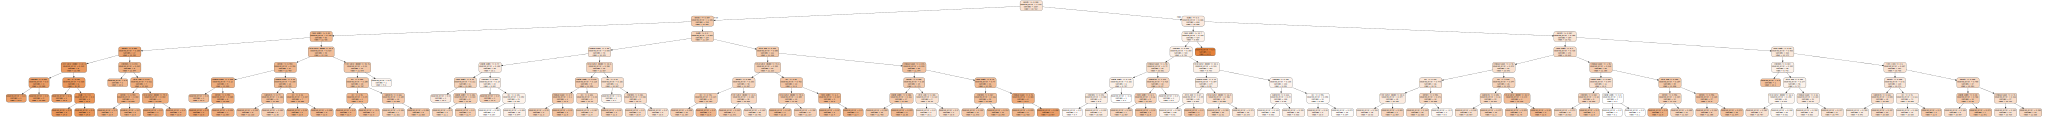

In [21]:
#Plotting the decision tree for the best estimator 
dot_data = export_graphviz(best, out_file =None,
               feature_names =X.columns, #feature names from dataset
               filled=True, 
                rounded=True, ) 
               
graph=graphviz.Source(dot_data)
graph #Pretty big, it is a continuous target afterall.

In [22]:
#What about the specific scores (rmse, r2, mae)? Let's try and extract them ...
print(model.cv_results_) #This is a dictionary and in order to extract info we need the keys

{'mean_fit_time': array([0.00794845, 0.01027438, 0.01088297, 0.01616061, 0.01483495,
       0.01379095, 0.01431308, 0.01498462, 0.01658163, 0.01757508,
       0.01962683, 0.02428143, 0.03621768, 0.02827371, 0.02615645,
       0.02403573, 0.02317877, 0.03529569, 0.02998183, 0.02328873]), 'std_fit_time': array([0.00242694, 0.01232767, 0.00572765, 0.00983175, 0.00749852,
       0.00445091, 0.00369082, 0.00290112, 0.00269272, 0.00327422,
       0.003267  , 0.00672341, 0.01192195, 0.0088545 , 0.00701567,
       0.00425534, 0.00453861, 0.01204177, 0.00911001, 0.00348049]), 'mean_score_time': array([0.00922704, 0.01609774, 0.00880342, 0.01099938, 0.0072149 ,
       0.00597116, 0.00580905, 0.00527901, 0.0052959 , 0.00520911,
       0.00587856, 0.00792961, 0.00880381, 0.00755454, 0.00670266,
       0.00624463, 0.00541598, 0.01039774, 0.00744771, 0.00542187]), 'std_score_time': array([0.00579116, 0.0214275 , 0.00574095, 0.01118248, 0.00311814,
       0.00241672, 0.00169065, 0.00152794, 0.0014433

In [23]:
#Which one of these do we need?
print(model.cv_results_.keys()) #get mean_test and std_test for all of our scores, and will need our param_max_depth as well 

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'split5_test_neg_mean_squared_error', 'split6_test_neg_mean_squared_error', 'split7_test_neg_mean_squared_error', 'split8_test_neg_mean_squared_error', 'split9_test_neg_mean_squared_error', 'split10_test_neg_mean_squared_error', 'split11_test_neg_mean_squared_error', 'split12_test_neg_mean_squared_error', 'split13_test_neg_mean_squared_error', 'split14_test_neg_mean_squared_error', 'split15_test_neg_mean_squared_error', 'split16_test_neg_mean_squared_error', 'split17_test_neg_mean_squared_error', 'split18_test_neg_mean_squared_error', 'split19_test_neg_mean_squared_error', 'split20_test_neg_mean_squared_error', 'split21_test_neg_mean_squared_error', 'split22_test_neg_mean_squared_error', 'sp

In [24]:
#Let's extract these scores based on depth!

#Scores: 

#Have negative mean squared error so need to take absolute value and square root to convert to root mean squared error
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
#nothing needs to be done for r2, it is the same
r2= model.cv_results_['mean_test_r2']
#Have negative mean absolute error so need to take absolute value
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])

#Get standard deviations as well...
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']

#Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])

#Let's take a look
final_model.style.hide_index()


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [25]:
#Remember!
#If we used mutiple params... you won't be able to get the scores as easily
#Say we wanted to get the scores based on max_depth still, but this time we used the parameter ccp_alpha as well
#Use the np.where function to search for the indices where the other parameter equals their best result, in this case it is .001
#This is an example code to find mse: model.cv_results_['mean_test_neg_mean_squared_error'][np.where((model.cv_results_['param_ccp_alpha'] == .001))]

## Let's see how we did.

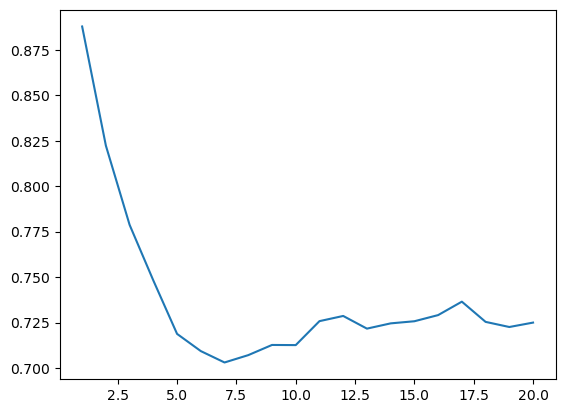

In [26]:
#Depth of 7 does in fact have the best rmse (lowest)
print(plt.plot(final_model.depth, final_model.rmse))

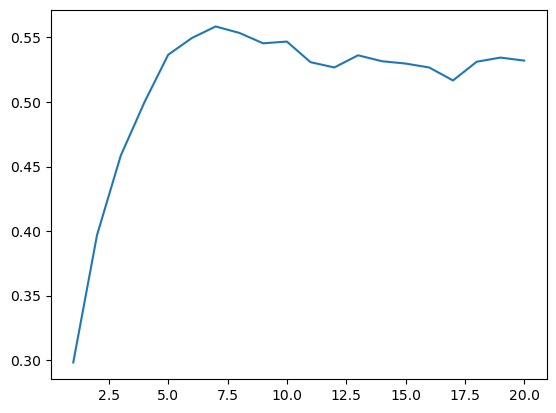

In [27]:
#Best r2 is at 7 as well!
print(plt.plot(final_model.depth, final_model.r2))

In [28]:
best #this matches our estimator, great!

DecisionTreeRegressor(max_depth=7, random_state=30)

## Variable Importance

In [29]:
#Variable importance for the best estimator, how much did each variable affect the ultimate decision making?
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

                      importance
density                 0.533976
quality                 0.116734
fixed acidity           0.104026
residual sugar          0.065236
total sulfur dioxide    0.032463
pH                      0.027416
chlorides               0.027104
citric acid             0.026332
sulphates               0.020771
volatile acidity        0.019362
text_rank               0.013376
free sulfur dioxide     0.013204


Axes(0.125,0.11;0.775x0.77)


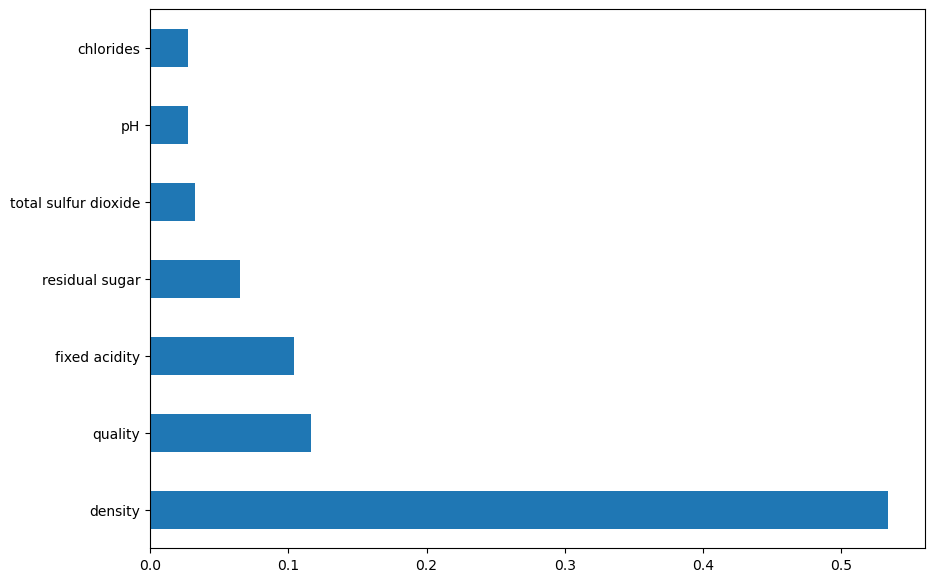

In [30]:
#Graph variable importance
plt.figure(figsize=(10,7))
print(varimp.importance.nlargest(7).plot(kind='barh')) #density had a huge impact!

## Let's make some predictions now

In [27]:
#Remember, 'best' is our best estimator. Let's use it to make predictions on our test data
pred=best.predict(X_test)
print(pred[:10])

[ 9.8097973  12.8        12.8         9.8097973  12.95714286  9.56153846
 12.43333333  9.93333333 10.02638889 13.6       ]


In [28]:
#This gives us accuracy, basically telling us how precise our model is
print(best.score(X_test, y_test))

0.5826219633648253


In [52]:
print(best.score(X_tune, y_tune)) #Test data is covered a lot better ... could be a sign of over or under fitting

0.43462112242567996


In [29]:
#This number is Rsquared which we want to be close to 1. 
print(metrics.r2_score(y_test, pred))

0.5826219633648253


In [30]:
#We want this number, RSME, to be less than .5 
print(np.sqrt(metrics.mean_squared_error(y_test, pred))) 

0.6749394620999498


In [31]:
#MAE we want to be below .5 as well
print(metrics.mean_absolute_error(y_test, pred)) #nice!

0.4864906923972274


## Pipeline Time!

In [32]:
#In this example we are going to use a pipeline for our preprocessing and test so our work can be further consolidated and easily replicated on any dataset
#To make things a little more interesting, let's impute values for NA's in our features instead of dropping them
#In order to do so we can't have any NA's in our target, let's check
print(winequality.alcohol.isna().sum())

10


In [33]:
#since there are NA's in our target, let's drop those rows and create a new dataframe to preserve our working environment
winequality_pipe=winequality.dropna(subset=['alcohol'])

In [34]:
#Split the features and the target
X1 = winequality_pipe.drop(columns="alcohol")
y1 = winequality_pipe.alcohol

In [35]:
#Get training, tuning, and test set
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=0.70, random_state=21)
X_tune1, X_test1, y_tune1, y_test1 = train_test_split(X_test1,y_test1,  train_size = 0.50,random_state=49)

In [36]:
#All prepocessing will be done inside of the pipeline, but the process will differ based on whether the feature is categorical or numerical
#So we must identify and divide these two types, let's see what we are working with
print(X1.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
quality                 float64
text_rank                object
dtype: object


In [37]:
#Now retrieve column labels for each type
numlist=X1.select_dtypes(np.float64).columns
catlist=X1.select_dtypes(object).columns

In [38]:
#Make pipeline for categorical data: first ordinal encode like before, then impute median of values for NA
catpipe= Pipeline([
    ('oh',OrdinalEncoder()),
    ('cat_imputer', SimpleImputer(strategy='median', missing_values= np.nan))
])

In [39]:
#Add together category pipeline with numerical preprocessing into a column transformer
#Let's impute median as well for the numerical NA's
#Since the numerical data only has one step for preprocessing we do not need to create a separate pipeline for it
data_pipeline = ColumnTransformer([
    ('numerical', SimpleImputer(strategy="median", missing_values= np.nan), numlist),
    ('categorical', catpipe, catlist),
])

In [40]:
#Combine the preprocessing with the model we wish to use, same model as before (DecisionTreeRegressor)
#make_pipeline simply names the steps automatically for us, with pipeline we must name them outselves as seen above.
pipe = make_pipeline(data_pipeline, reg)

In [41]:
#The params will be the same, but we have to reset them since in this pipeline example, the keys change in the resulting dictionary
params_pipe = {}
params_pipe["decisiontreeregressor__max_depth"] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [42]:
#Instead of just passing our model to the hyperparameter search, this time we pass the preprocessing as well
#This allows for preprocessing to occur on every fold which is computational heavier, but better simulates the real world
#In the previous example we didn't need this since we did not do any imputing, 
#but in this example we need it because the pipeline makes sure the imputed medians are unique and accurate to the specific folds
#Scoring and cross validation will be the same as before
search_pipe = GridSearchCV(pipe,params_pipe, cv= kf, scoring =scoring, refit= 'r2')

In [43]:
#Let's fit our model using our training data
model_pipe = search_pipe.fit(X_train1,y_train1)

In [44]:
#Let's get our results!
best_pipe= model_pipe.best_estimator_['decisiontreeregressor']
print(best_pipe) #Wow, a different depth!

DecisionTreeRegressor(max_depth=6, random_state=30)


In [45]:
#Let's see which one is better...
#First we have to preprocess our testing data using our column transformer to fit our model
X_test1p= data_pipeline.fit_transform(X_test1)
print(best_pipe.score(X_test1p,y_test1))

0.45441296270115594


In [46]:
#Testing data got worse, but tuning data got better! 
X_tune1p= data_pipeline.fit_transform(X_tune1)
print(best_pipe.score(X_tune1p,y_tune1))

0.5225930783100188


In [47]:
#RMSE got worse...
pred1=best_pipe.predict(X_test1p)
print(np.sqrt(metrics.mean_squared_error(y_test1, pred1)))

0.7392799227254304


In [48]:
#Let's get the scores now
print(model_pipe.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_decisiontreeregressor__max_depth', 'params', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'split5_test_neg_mean_squared_error', 'split6_test_neg_mean_squared_error', 'split7_test_neg_mean_squared_error', 'split8_test_neg_mean_squared_error', 'split9_test_neg_mean_squared_error', 'split10_test_neg_mean_squared_error', 'split11_test_neg_mean_squared_error', 'split12_test_neg_mean_squared_error', 'split13_test_neg_mean_squared_error', 'split14_test_neg_mean_squared_error', 'split15_test_neg_mean_squared_error', 'split16_test_neg_mean_squared_error', 'split17_test_neg_mean_squared_error', 'split18_test_neg_mean_squared_error', 'split19_test_neg_mean_squared_error', 'split20_test_neg_mean_squared_error', 'split21_test_neg_mean_squared_error', 'split22_test_neg_m

In [49]:
#Same as before, since only one parameter used, this will be rather straight forward, no need for np.where
mean_sq_err_p = np.sqrt(abs(model_pipe.cv_results_['mean_test_neg_mean_squared_error']))
r2_p= model_pipe.cv_results_['mean_test_r2']
mae_p= abs(model_pipe.cv_results_['mean_test_neg_mean_absolute_error'])

#Get standard deviations as well...
SDmse_p =  model_pipe.cv_results_['std_test_neg_mean_squared_error']
SDr2_p= model_pipe.cv_results_['std_test_r2']
SDmae_p= model_pipe.cv_results_['std_test_neg_mean_absolute_error']

depth_p= np.unique(model_pipe.cv_results_['param_decisiontreeregressor__max_depth'].data)


In [50]:
final_model_p = pd.DataFrame(list(zip(depth_p, mean_sq_err_p, r2_p,mae_p, SDmse_p,SDr2_p,SDmae_p)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])
final_model_p.style.hide_index()

/var/folders/x_/qkfj00656_qg6nsj5fclf5sc0000gn/T/ipykernel_11509/2782303687.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  final_model_p.style.hide_index()


depth,rmse,r2,mae,rmseSD,r2SD,maeSD
1,0.897000,0.288776,0.710496,0.122560,0.085367,0.046246
2,0.808772,0.420766,0.616632,0.103677,0.080109,0.037611
3,0.788328,0.449136,0.607771,0.101415,0.087028,0.042018
4,0.716900,0.540868,0.551823,0.085498,0.096267,0.040984
5,0.704596,0.555940,0.530999,0.105587,0.114895,0.045043
6,0.685200,0.582425,0.511537,0.092737,0.086871,0.044355
7,0.695145,0.570937,0.505704,0.109454,0.095593,0.047168
8,0.697389,0.566667,0.500381,0.093260,0.091349,0.044569
9,0.711649,0.549793,0.497014,0.109108,0.100227,0.049792
10,0.722031,0.537066,0.498313,0.115660,0.103001,0.052840


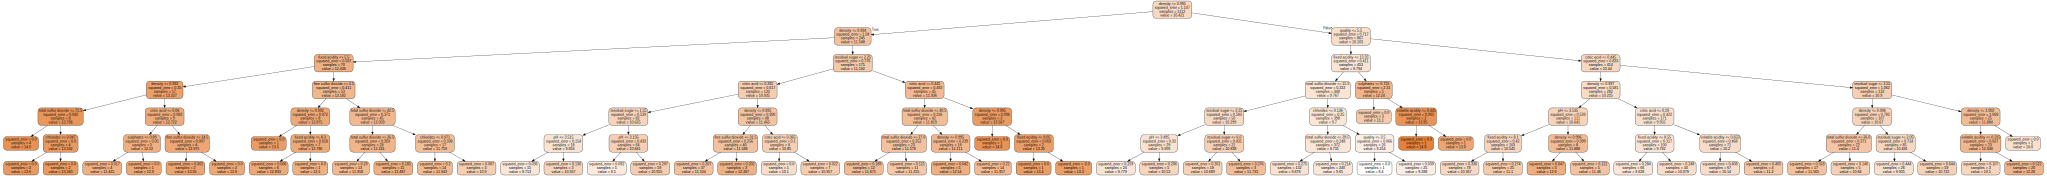

In [51]:

dot_data = export_graphviz(best_pipe, out_file =None,
               feature_names =X1.columns,
               filled=True, 
                rounded=True, ) 
               
graph=graphviz.Source(dot_data)
graph